## Importing Libraries and set up runtime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pycocotools.coco import COCO
import random
import cv2
import time
import os
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import albumentations as A
from google.colab import drive


In [ ]:
drive.mount('/content/drive')
ANN_DIR = '/content/drive/MyDrive/UniBO/ML4CV'
RESNET_PATH = model_zoo.load_url('https://download.pytorch.org/models/resnet18-5c106cde.pth')
DATASET_FOLDER = "/content/lemon-dataset"
INPUT_IMG_SIZE = (256, 256)

In [ ]:
DEVICE = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  DEVICE = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Data Exploration

### Download and manage dataset

In [ ]:
! git clone https://github.com/softwaremill/lemon-dataset.git
! unzip /content/lemon-dataset/data/lemon-dataset.zip

In [ ]:
coco = COCO(f'{DATASET_FOLDER}/annotations/instances_default.json')
catIds = coco.loadCats()
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=2.37s)
creating index...
index created!


### Inspecting the format of images and annotations

In [ ]:
img[0]

{'id': 0,
 'date_captured': 0,
 'coco_url': '',
 'file_name': 'images/0001_A_H_0_A.jpg',
 'license': 0,
 'flickr_url': '',
 'height': 1056,
 'width': 1056}

In [ ]:
images_df = pd.DataFrame.from_dict(img).set_index('id').drop(
    ['date_captured', 'coco_url', 'license', 'flickr_url'], axis=1)
images_df.rename_axis('image', inplace=True)
images_df.head()

,file_name,height,width
image,,,
0,images/0001_A_H_0_A.jpg,1056,1056
100,images/0003_A_V_150_A.jpg,1056,1056
101,images/0003_A_V_15_A.jpg,1056,1056
102,images/0003_A_V_165_A.jpg,1056,1056
103,images/0003_A_V_30_A.jpg,1056,1056


In [ ]:
cats = coco.loadCats(coco.getCatIds())
cats

[{'id': 1, 'supercategory': '', 'name': 'image_quality'},
 {'id': 2, 'supercategory': '', 'name': 'illness'},
 {'id': 3, 'supercategory': '', 'name': 'gangrene'},
 {'id': 4, 'supercategory': '', 'name': 'mould'},
 {'id': 5, 'supercategory': '', 'name': 'blemish'},
 {'id': 6, 'supercategory': '', 'name': 'dark_style_remains'},
 {'id': 7, 'supercategory': '', 'name': 'artifact'},
 {'id': 8, 'supercategory': '', 'name': 'condition'},
 {'id': 9, 'supercategory': '', 'name': 'pedicel'}]

In [ ]:
anns = coco.loadAnns(coco.getAnnIds())
anns[10]

{'id': 11,
 'iscrowd': 0,
 'area': 640.0,
 'category_id': 5,
 'image_id': 100,
 'segmentation': [[551.0,
   761.0,
   536.8952473599911,
   765.5021823999905,
   525.0707507199913,
   775.1767705599905,
   518.9793433599916,
   779.4765875199919,
   514.679526399992,
   787.0012671999921,
   509.30475519999163,
   791.6594022399913,
   501.78007551999144,
   795.2425830399916,
   500.0,
   802.0,
   509.0,
   802.0,
   517.0,
   800.0,
   523.0,
   797.0,
   526.8623411199915,
   794.1676287999908,
   531.5204761599907,
   788.7928575999904,
   535.103656959991,
   783.0597683199903,
   539.0451558399909,
   777.3266790399921,
   541.5533823999922,
   771.9519078399917,
   542.2700185599915,
   770.5186355199912,
   544.0616089599916,
   768.3687270399914]],
 'bbox': [500.0, 761.0, 51.0, 41.0]}

### Visualization

In [ ]:
def plot_image(image_id, coco):
    """Plot some images with the corresponding annotation mask"""
    #read the image
    img = coco.loadImgs(image_id)[0]
    image = cv2.cvtColor(cv2.imread(f"{DATASET_FOLDER}/{img['file_name']}"), cv2.COLOR_BGR2RGB)
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        color = ['y', 'c', 'g', 'm', 'r', 'b', 'k', 'w', 'sienna'][annotations[i]['category_id']-1]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], color, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], color, alpha=0.8)
  
    #show results
    plt.show()

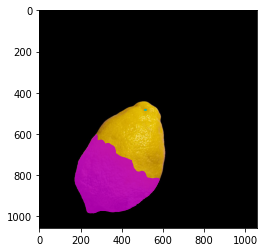

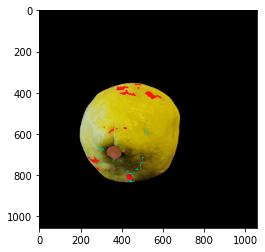

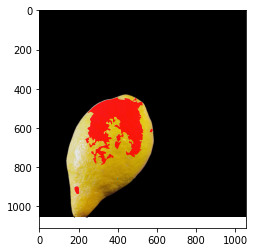

In [ ]:
#Plotting a few random images
np.random.seed(17)
img_num = []
rand = np.random.randint(0, len(coco.getImgIds()), 3)
for i in rand:
    img_num.append(coco.getImgIds()[i])
for ids in img_num:
    plot_image(ids, coco)

### Managing categories of the dataset

In [ ]:
# COCO categories
CATEGORIES = coco.loadCats(coco.getCatIds())
CLASSES = [cat['name'] for cat in CATEGORIES]
print('Original class names: ', CLASSES)

Original class names:  ['image_quality', 'illness', 'gangrene', 'mould', 'blemish', 'dark_style_remains', 'artifact', 'condition', 'pedicel']


As we can deduce from the list of the classes above, we have some categories that are not useful for our task. 

We simply remove them, ignoring the relative annotations.

In [ ]:
# Remove classes not useful for our task
CLASSES =['illness', 'gangrene', 'mould', 'blemish', 'dark_style_remains', 'pedicel']
N_CLASSES = len(CLASSES)
print('Actual number of classes: ', N_CLASSES)
print('Actual class names: ', CLASSES)

Actual number of classes:  6
Actual class names:  ['illness', 'gangrene', 'mould', 'blemish', 'dark_style_remains', 'pedicel']


## Managing the data

### Split dataset in Train, Validation and Test Set

In [ ]:
# Python package useful for splitting a COCO dataset
"""
! pip install pyodi
! pyodi coco random-split /content/lemon-dataset/annotations/instances_default.json /content/lemon-dataset/annotations/lemon --val-percentage 0.3
! pyodi coco random-split /content/lemon-dataset/annotations/lemon_val.json /content/lemon-dataset/annotations/lemon_test --val-percentage 0.3 
! mv /content/lemon-dataset/annotations/lemon_test_train.json /content/lemon-dataset/annotations/lemon_test.json 
! mv /content/lemon-dataset/annotations/lemon_test_val.json /content/lemon-dataset/annotations/lemon_val.json 
""";

In [ ]:
def organize_set(mode):
    """Returns the COCO object and the images of the specified set """    
    annFile = f'{ANN_DIR}/lemon_{mode}.json'
    coco = COCO(annFile)
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    random.shuffle(images)
    return images, coco
  
train_images, coco_train = organize_set('train')
val_images, coco_val = organize_set('val')
test_images, coco_test = organize_set('test')

loading annotations into memory...
Done (t=3.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


### Functions for managing the data

In [ ]:
def getClassName(classID, cats):
    """Returns the class name given in input a class ID """
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    """Returns the image normalized and resized given the corresponding filename """
    # Read and normalize an image
    img = cv2.imread(f"{img_folder}/{imageObj['file_name']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0  
    # Resize
    img = cv2.resize(img, input_image_size)
    return img

def getBinaryMasks(imageObj, classes, coco, catIds, input_image_size):
    """Build a semantic mask with shape (H × W × C+1), where C is the number of 
    predefined categories (+1 for the background).
    For each channel corresponing to a specific class we create a semantic binary mask."""
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        # Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        # If the index of the class is equal to the index iterating through the annotation 
        # add the binary mask to the array
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    # Adding background mask into the training mask in position 0
    defects_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(defects_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

In order to feed the network with images and annotations, we create a custom Dataset class that allow us to store the samples and their corresponding labels.

Inside the `__getitem__` method we apply the **Data augmentation** using the Albumentations library.

In [ ]:
class Lemon_Dataset(Dataset):
    """Custom dataset class to store the samples and apply data augmentation. """
    def __init__(self, images, coco):
        self.images = images
        self.coco = coco
        self.catIds = coco.getCatIds(catNms=CLASSES)

    def __getitem__(self, idx):
        img = self.images[idx]
        # Retrieve Image
        image = getImage(img, DATASET_FOLDER, INPUT_IMG_SIZE)
        # Create Mask
        mask = getBinaryMasks(img, CLASSES, self.coco, self.catIds, INPUT_IMG_SIZE)
        
        # Apply data augmentation
        aug = A.Compose([
          A.RandomSizedCrop(min_max_height=(150, 201), height=INPUT_IMG_SIZE[0], width=INPUT_IMG_SIZE[1], p=0.3),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),              
          A.RandomRotate90(p=0.5),
          ])
        
        random.seed(11)
        augmented = aug(image=image, mask=mask)
        return augmented['image'].transpose(2, 0, 1), augmented['mask'].transpose(2, 0, 1)

    def __len__(self):
        return len(self.images)

In [ ]:
train_dataset = Lemon_Dataset(train_images, coco_train)
val_dataset = Lemon_Dataset(val_images, coco_val)
test_dataset = Lemon_Dataset(test_images, coco_test)

print(f'Number of train images: {len(train_dataset)}')
print(f'Number of test images: {len(test_dataset)}')
print(f'Number of val images: {len(val_dataset)}')

Number of train images: 1921
Number of test images: 558
Number of val images: 211


Then we use the DataLoader to wraps an iterable around the Dataset object in order to enable easy access to the samples.

In [ ]:
BATCH_SIZE = 16

train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              pin_memory=True, 
                                              num_workers=2,
                                              collate_fn= lambda batch: tuple(zip(*batch)))

val_data_loader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              pin_memory=True, 
                                              num_workers=2,
                                              collate_fn= lambda batch: tuple(zip(*batch)))

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              pin_memory=True, 
                                              num_workers=2,
                                              collate_fn= lambda batch: tuple(zip(*batch)))

## Model architecture

### Defining model components

In [ ]:
class Resnet_block(nn.Module):
  """Residual block of the ResNet-18 model """
  def __init__(self, in_channels, out_channels, stride=1, downsample=False):
      super(Resnet_block, self).__init__()
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.stride = stride
      if downsample:
        self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
      else: self.downsample = None

  def forward(self, x):
      residual = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)

      if self.downsample is not None:
          residual = self.downsample(x)

      out += residual
      out = self.relu(out)

      return out



class PPM(nn.Module):
    """ Pyramid scene parsing network." """
    def __init__(self, in_channels, out_channels, sizes=(2, 3, 4, 6)):
        super(PPM, self).__init__()
        #self.ppm_stages = []
        self.ppm_stages = nn.ModuleList([self.build_stage(in_channels, out_channels, size) for size in sizes])
        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels + len(sizes)*out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(0.1)
            )
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def build_stage(self, in_channels, out_channels, size):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(size, size)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)     
        )

    def forward(self, features):
        # Apply PPM convs
        out_conv = [stage(features) for stage in self.ppm_stages]
        # Upsample
        out_up = [F.interpolate(stage, size=(features.size(2), features.size(3)), mode='bilinear', align_corners=True) for stage in out_conv]
        # Concat output of the stages + input features
        down_feat = self.down(features)
        out_cat = torch.cat(out_up + [down_feat], 1)
        # Apply final conv
        out = self.final_conv(out_cat)
        return out



class FAM(nn.Module):
  """ Flow Align Module """
  def __init__(self, in_channels, out_channels):
      super(FAM, self).__init__()
      self.conv_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
      self.flow_conv = nn.Conv2d(out_channels*2, 2, kernel_size=3, padding=1, bias=False)

  def forward(self, left_feature, right_feature):
      original_left_feat = right_feature
      left_feature = self.conv_1x1(left_feature)
      right_feature = self.conv_1x1(right_feature)
      right_feature = F.interpolate(right_feature, size=(left_feature.size(2), left_feature.size(3)), mode='bilinear', align_corners=True)
      out_cat = torch.cat([right_feature, left_feature], 1)
      flow_field = self.flow_conv(out_cat)

      # Warping operation
      out_h, out_w = left_feature.size(2), left_feature.size(3)
      B, _, _, _ = original_left_feat.size()
      norm = torch.tensor([[[[out_w, out_h]]]]).type_as(original_left_feat).to(original_left_feat.device)
      w = torch.linspace(-1.0, 1.0, out_h).view(-1, 1).repeat(1, out_w)
      h = torch.linspace(-1.0, 1.0, out_w).repeat(out_h, 1)
      grid = torch.cat((h.unsqueeze(2), w.unsqueeze(2)), 2)
      grid = grid.repeat(B, 1, 1, 1).type_as(original_left_feat).to(original_left_feat.device)
      grid = grid + flow_field.permute(0, 2, 3, 1) / norm
      output = F.grid_sample(original_left_feat, grid, align_corners=True)
      return output

### SFNet with ResNet18 backbone

In [ ]:
class SFNet(nn.Module):
  """SFNet with a ResNet-18 backbone. """
  def __init__(self, num_classes, PPM_flag=True, FAM_flag=True):
    super(SFNet, self).__init__()

    self.PPM_flag = PPM_flag
    self.FAM_flag = FAM_flag
    
    # ResNet18 Blocks
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = nn.Sequential(
        Resnet_block(in_channels=64, out_channels=64),
        Resnet_block(in_channels=64, out_channels=64))
    
    self.layer2 = nn.Sequential(
        Resnet_block(in_channels=64, out_channels=128, stride=2, downsample=True),
        Resnet_block(in_channels=128, out_channels=128))
    
    self.layer3 = nn.Sequential(
        Resnet_block(in_channels=128, out_channels=256, stride=2, downsample=True),
        Resnet_block(in_channels=256, out_channels=256))
    
    self.layer4 = nn.Sequential(
        Resnet_block(in_channels=256, out_channels=512, stride=2, downsample=True),
        Resnet_block(in_channels=512, out_channels=512))
    
    self.top_layer = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=64, kernel_size=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True))

    # Pyramid scene parsing module
    self.PPM = PPM(in_channels=512, out_channels=64)

    # Flow Align Module
    self.FAM = FAM(in_channels=64, out_channels=64)

    # Feature pyramid network
    self.lat_conn_4 = self.build_lat_conn(in_channels=256, out_channels=64)
    self.lat_conn_3 = self.build_lat_conn(in_channels=128, out_channels=64)
    self.lat_conn_2 = self.build_lat_conn(in_channels=64, out_channels=64)

    self.smooth_layer = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
    )

    self.prediction_block = nn.Sequential(
        nn.Conv2d(in_channels=4*64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=num_classes+1, kernel_size=1)
    )
  
  def build_lat_conn(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    _, _, target_h, target_w = x.size()

    # ResNet
    x = self.conv1(x)
    x = self.bn1(x) 
    x = self.relu1(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    s2 = x
    x = self.layer2(x)
    s3 = x
    x = self.layer3(x)
    s4 = x
    x = self.layer4(x)

    if self.PPM_flag:
      # Use PPM
      f5 = self.PPM(x)
    else:
      # Use a simple conv_1x1
      f5 = self.top_layer(x)

    # FPN with FAM module
    lat_conn_4 = self.lat_conn_4(s4)
    f5_flow = self.FAM(lat_conn_4, f5)
    f4 = F.interpolate(f5_flow, size=(lat_conn_4.size(2), lat_conn_4.size(3)), mode='bilinear') + lat_conn_4
    f4 = self.smooth_layer(f4)

    lat_conn_3 = self.lat_conn_3(s3)
    f4_flow = self.FAM(lat_conn_3, f4)
    f3 = F.interpolate(f4_flow, size=(lat_conn_3.size(2), lat_conn_3.size(3)), mode='bilinear') + lat_conn_3
    f3 = self.smooth_layer(f3)

    lat_conn_2 = self.lat_conn_2(s2)
    f3_flow = self.FAM(lat_conn_2, f3)
    f2 = F.interpolate(f3_flow, size=(lat_conn_2.size(2), lat_conn_2.size(3)), mode='bilinear') + lat_conn_2
    f2 = self.smooth_layer(f2)

    if self.FAM_flag:
      # Upsample with FAM
      f3 = F.interpolate(self.FAM(f2, f3), size=(f2.size(2), f2.size(3)), mode='bilinear') + f2
      f4 = F.interpolate(self.FAM(f2, f4), size=(f2.size(2), f2.size(3)), mode='bilinear') + f2
      f5 = F.interpolate(self.FAM(f2, f5), size=(f2.size(2), f2.size(3)), mode='bilinear') + f2
    else:
      f3 = F.interpolate(f3, size=(f2.size(2), f2.size(3)), mode='bilinear')
      f4 = F.interpolate(f4, size=(f2.size(2), f2.size(3)), mode='bilinear')
      f5 = F.interpolate(f5, size=(f2.size(2), f2.size(3)), mode='bilinear')
    
    # Concatenate features and last layers
    out = torch.cat((f2, f3, f4, f5), 1)
    out = self.prediction_block(out)
    out = F.interpolate(out, size=(target_h, target_w), mode='bilinear')

    return out

In [ ]:
def SF_ResNet18(num_classes, pretrained=False, PPM_flag=True, FAM_flag=True):
    """Constructs a SFNet based on ResNet-18 model. """
    model = SFNet(num_classes, PPM_flag=PPM_flag, FAM_flag=FAM_flag)
    if pretrained:
        model.load_state_dict(RESNET_PATH, strict=False)
    return model

## Train and Test Functionalities

In [ ]:
def compute_IoU_values(predictions, gt_labels):
  """Computes the mean Intersection over Union metric"""
  batch_intersections, batch_unions = [], []
  for pred, label in zip(predictions, gt_labels):
    pred = F.softmax(pred, dim=0)
    pred = torch.argmax(pred, dim=0).squeeze(1)
    label = torch.argmax(label, dim=0).squeeze(1)
    
    # Reshape for faster computation
    pred = pred.view(-1)
    label = label.view(-1)

    img_intersections, img_union = [], []
    for sem_class in range(1, N_CLASSES+1): # Background excluded from computation
      pred_idxs = (pred == sem_class)
      target_idxs = (label == sem_class)
     
      class_intersection = (pred_idxs[target_idxs]).long().sum().item()
      class_union = pred_idxs.long().sum().item() + target_idxs.long().sum().item() - class_intersection
      img_intersections.append(class_intersection)
      img_union.append(class_union)

    batch_intersections.append(img_intersections)
    batch_unions.append(img_union)

  return np.sum(batch_intersections, axis=0), np.sum(batch_unions, axis=0)

In [ ]:
def train(model, train_loader, criterion, optimizer, epoch, verbose=True):
    """Trains a neural network for one epoch"""
    log_interval = 100
    start_time = time.time()
    num_batches = len(train_loader) 

    losses, intersections, unions = [], [], []

    model.train()
    for idx_batch, (images, targets) in enumerate(train_loader):        
        optimizer.zero_grad()

        images = torch.from_numpy(np.asarray(images)).to(DEVICE).type(torch.cuda.FloatTensor)
        targets = torch.from_numpy(np.asarray(targets)).to(DEVICE).type(torch.cuda.FloatTensor)

        predicted_labels = model(images)
        
        loss = criterion(predicted_labels, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        i, u = compute_IoU_values(predicted_labels, targets)

        intersections.append(i)
        unions.append(u)

        if idx_batch % log_interval == 0 and log_interval > 0:                               
            elapsed = time.time() - start_time
            if verbose:
                print(f'| epoch {(epoch if epoch else 0):3d} | {idx_batch:5d}/{num_batches:5d} batches' 
                      + f' | loss {losses[-1]:.5f}')
           
            start_time = time.time()      

    mIoU = np.mean(np.sum(intersections, axis=0)/np.sum(unions,axis=0))
    return losses, mIoU


def evaluate(dataloader, model, criterion, return_class_IoU=False):
    ''' Evaluates 'model' over the dataloader'''
    model.eval()
    losses, intersections, unions = [], [], []
    with torch.no_grad():
        for idx, (images, targets) in enumerate(dataloader):
            images = torch.from_numpy(np.asarray(images)).to(DEVICE).type(torch.cuda.FloatTensor)
            targets = torch.from_numpy(np.asarray(targets)).to(DEVICE).type(torch.cuda.FloatTensor)
            predicted_labels = model(images)
            loss = criterion(predicted_labels, targets)
            losses.append(loss.item())
            i, u = compute_IoU_values(predicted_labels, targets)
            intersections.append(i)
            unions.append(u)
    
    mIoU = np.mean(np.sum(intersections, axis=0)/np.sum(unions,axis=0))
   
    if return_class_IoU:
      class_IoUs = np.sum(intersections, axis=0)/np.sum(unions,axis=0)
      return mIoU, class_IoUs
    else:
      return losses, mIoU

In [ ]:
def train_loop(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    epochs,
    early_stop_patience,
    save_model = False,
    verbose = True):

    """Executes the training loop."""

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1, verbose=False)
    highlight = lambda _:f'{"-"*(len(_)+4)}\n  {_}\n{"-"*(len(_)+4)}'
    last_loss = 100
    last_test_mIoU = 0
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        train_losses, train_mIoU = train(model, train_dataloader, criterion, optimizer, epoch, verbose)

        test_losses, test_mIoU = evaluate(test_dataloader, model, criterion)

        current_test_loss = np.mean(test_losses)

        scheduler.step()

        if verbose:
            print(f'Training mIoU: {train_mIoU:8.3f}')
            print(highlight(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
            f'test mIoU {test_mIoU:8.3f} | test loss:{current_test_loss:8.3f}'))
        else:
            print(end=f"\rDoing epoch: {epoch:2}", flush=True)
        
        if save_model and test_mIoU > last_test_mIoU:
          if not os.path.exists(f'{ANN_DIR}/checkpoints'):
              os.makedirs(f'{ANN_DIR}/checkpoints')
          
          path_checkpoint = os.path.join(f'{ANN_DIR}/checkpoints', f'best_model.bin')
          torch.save(model.state_dict(), path_checkpoint)
      
        #Early stopping
        if current_test_loss > last_loss:
            trigger_times += 1
            if trigger_times >= early_stop_patience:
                print("\n === Early Stopping ===\n")
                print("\Test mean IoU: ", test_mIoU)
                break
        else:  trigger_times = 0
        last_loss = current_test_loss

    if epoch==epochs:
        print("Test mean IoU: ", test_mIoU)
  
    return test_mIoU

In [ ]:
def hp_tuning(
    train_dataloader,
    val_dataloader,
    epochs,
    hyper_params,
    verbose = True):
  
    """Executes a tuning of the model given the list of hyperparameters in input"""
    
    results = pd.DataFrame(columns=list(hyper_params.keys()) + ["val_mIoU"])
  
    for opt in hyper_params['optimizer']:
      for LR in hyper_params['learning_rate'][opt]:
        for PPM_flag in hyper_params['PPM_flag']:
          for FAM_flag in hyper_params['FAM_flag']:

            model = SF_ResNet18(num_classes=N_CLASSES, pretrained=True, PPM_flag=PPM_flag, FAM_flag=FAM_flag).to(DEVICE)

            val_mIoU = train_loop(
                  model = model,
                  train_dataloader = train_data_loader,
                  test_dataloader = val_data_loader,
                  optimizer = torch.optim.Adam(model.parameters(), lr=LR) if opt=="Adam" 
                                else torch.optim.SGD(model.parameters(), lr=LR),
                  criterion = torch.nn.CrossEntropyLoss(),
                  epochs = epochs,
                  early_stop_patience = 3,
                  verbose = False)
            
            results = results.append({"optimizer": opt, "learning_rate": LR, "PPM_flag": PPM_flag, 
                                      "FAM_flag": FAM_flag, "val_mIoU": val_mIoU}, ignore_index=True)
              
    return results

## Hyperparameters tuning of the model

In [ ]:
hyper_params = {"optimizer": ["Adam", "SGD"],
            "learning_rate": { "Adam": np.linspace(0.00008, 0.0003, num=3), 
                               "SGD": np.linspace(0.08, 0.3, num=3)},
             "PPM_flag": [True, False],
             "FAM_flag": [True, False],
            }

results = hp_tuning(
            train_dataloader = train_data_loader,
            val_dataloader = val_data_loader,
            epochs = 20,
            hyper_params = hyper_params,
            verbose=False)

## Training the model with best hyperparameters

In [ ]:
model = SF_ResNet18(num_classes=N_CLASSES, pretrained=True, PPM_flag=True, FAM_flag=False).to(DEVICE)

In [ ]:
_ = train_loop(
    model = model,
    train_dataloader = train_data_loader,
    test_dataloader = test_data_loader,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion = torch.nn.CrossEntropyLoss(),
    epochs = 30,
    early_stop_patience = 3,
    save_model = True)

| epoch   1 |     0/  121 batches | loss 1.66328
| epoch   1 |   100/  121 batches | loss 0.90751
Training mIoU:    0.031
--------------------------------------------------------------------------------
  | end of epoch   1 | time: 158.62s | test mIoU    0.046 | test loss:   0.928
--------------------------------------------------------------------------------
| epoch   2 |     0/  121 batches | loss 0.82863
| epoch   2 |   100/  121 batches | loss 0.60277
Training mIoU:    0.082
--------------------------------------------------------------------------------
  | end of epoch   2 | time: 159.65s | test mIoU    0.081 | test loss:   0.571
--------------------------------------------------------------------------------
| epoch   3 |     0/  121 batches | loss 0.50778
| epoch   3 |   100/  121 batches | loss 0.36970
Training mIoU:    0.092
--------------------------------------------------------------------------------
  | end of epoch   3 | time: 160.43s | test mIoU    0.113 | test loss: 

## Model evaluation

In [ ]:
# Loading best model
model = SF_ResNet18(num_classes=N_CLASSES, pretrained=True).to(DEVICE)
model.load_state_dict(torch.load(f'{ANN_DIR}/checkpoints/best_model.bin'))

### Visualize predictions

In [ ]:
def plot_predictions(n_img_to_display=3):
  np.random.seed(28)
  color_dict = {0: 'black',
                1: 'purple',
                2: 'grey',
                3: 'blue',
                4: 'orange',
                5: 'red',
                6: 'green'}
  cm = ListedColormap(color_dict.values())

  for i in range(n_img_to_display):
    img = test_images[np.random.randint(0, len(test_images))]
    image = getImage(img, DATASET_FOLDER, INPUT_IMG_SIZE).transpose(2, 0, 1)
    # Compute ground truth mask
    gt_mask = getBinaryMasks(img, CLASSES, coco_test, coco.getCatIds(catNms=CLASSES), INPUT_IMG_SIZE)
    gt_mask = np.argmax(gt_mask, axis=2)
    # Compute model prediction
    model.eval()
    predicted_mask = model(torch.from_numpy(np.expand_dims(image, axis=0)).to(DEVICE).type(torch.cuda.FloatTensor))
    predicted_mask = F.softmax(predicted_mask.squeeze(0), dim=0)
    predicted_mask = torch.argmax(predicted_mask, dim=0).cpu().numpy()
    
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    display_list = [image.transpose(1, 2, 0), gt_mask, predicted_mask]

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      if i == 0:
        plt.imshow(display_list[i])
      else:
        plt.imshow(display_list[0], cmap='gray')
        plt.imshow(display_list[i], cmap=cm, alpha=0.7, interpolation='none', vmin=min(color_dict), vmax=max(color_dict))
      plt.axis('off')
    plt.show()

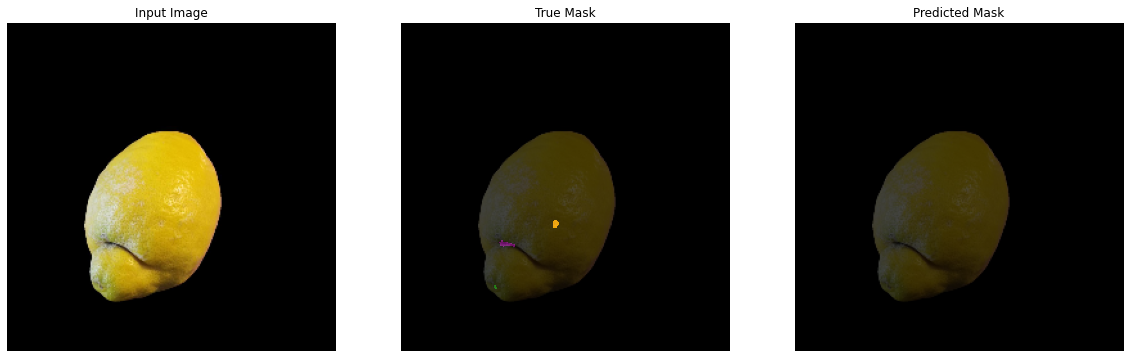

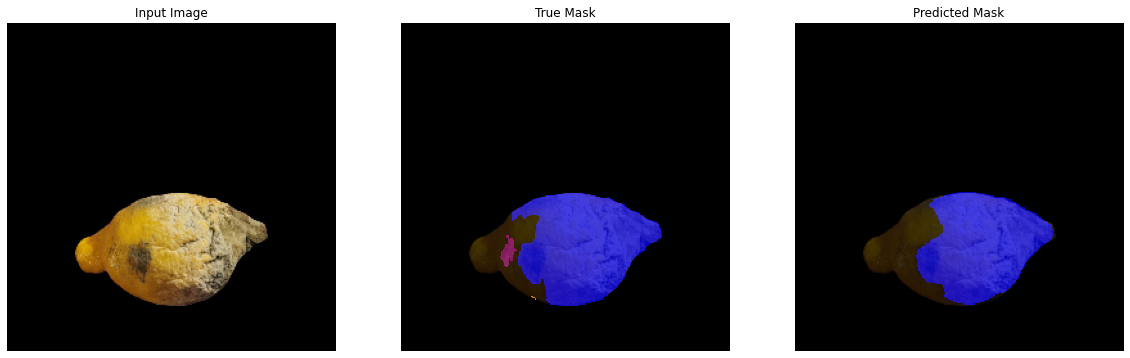

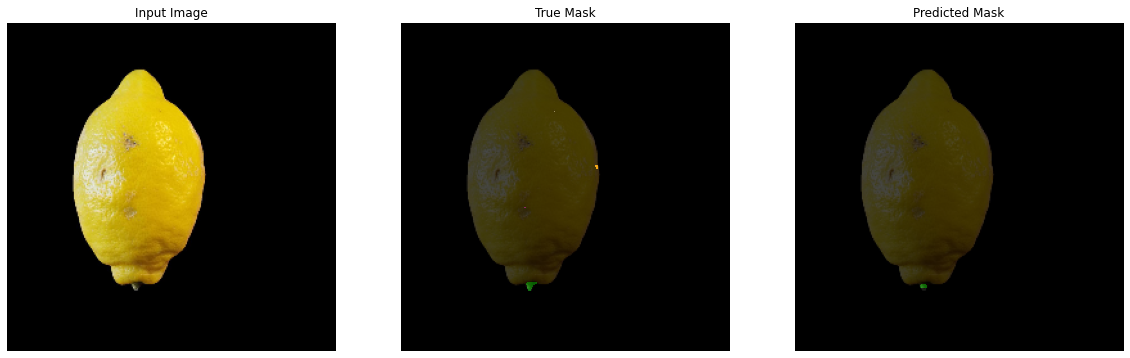

In [ ]:
plot_predictions(3)

### Evaluation of the best model

In [ ]:
class_IoUs, test_mIoU = evaluate(test_data_loader, model, criterion=torch.nn.CrossEntropyLoss())
print(f'mIoU on the test set: {round(test_mIoU, 3)}%')

mIoU on the test set: 0.386%

## Conclusions

### Error analysis

In [ ]:
for i in range(len(CLASSES)):
  print(f'IoU of class {CLASSES[i]}: {round(class_IoUs[i], 2)}%')

IoU of class illness: 0.39%
IoU of class gangrene: 0.25%
IoU of class mould: 0.81%
IoU of class blemish: 0.47%
IoU of class dark_style_remains: 0.01%
IoU of class blemish: 0.37%

illness: 7.01%
gangrene: 4.88%
mould: 73.01%
blemish: 9.33%
dark_style_remains: 2.09%
pedicel: 3.68%



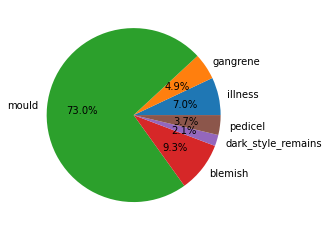

In [ ]:
# Check class composition of the training set

classes_counter = np.zeros(len(CLASSES)+1)
for img in train_images:
  image = getImage(img, DATASET_FOLDER, INPUT_IMG_SIZE)
  mask = getBinaryMasks(img, CLASSES, coco_train, coco_train.getCatIds(catNms=CLASSES), INPUT_IMG_SIZE)
  for c in range(0, len(CLASSES)+1):
    classes_counter[c] += len(mask[:,:,c][mask[:,:,c]==1])

tot = np.sum(classes_counter[1:])
for c in range(1, len(CLASSES)+1):
  print(f'{CLASSES[c-1]}: {round(100*classes_counter[c]/tot, 2)}%')
print()

fig, ax = plt.subplots()
ax.pie(classes_counter[1:], labels=CLASSES, autopct='%1.1f%%')
plt.show()



*   The first consideration that we can do is that the model has perfor-
mances that are strictly related to the composition of the classes within the training set. Analyzing in fact the per-class Intersection over Union metric, we can notice a great discrepancy between the value of the most popular class ( mould with 0.81) and the value of the less popular ( dark style remains with 0.01). All the other classes have instead a value of the IoU that is around 0.3.

*   Another consideration that we can do is that, by looking at the images, it is difficult to find the difference between some classes that result to be very similar, even by a human observer. Most of the mistakes that our model performs are effectively executed confusing similar classes like for example *mould* and *blemish*.

*   In the end, by observing some images with the ground truth mask, we noticed that the majority of the defects on lemons are very tiny; in this kind of situation our model has a lot of difficulties in detecting the imperfections


### Final remarks and future works

The results in terms of mIoU turned out to be not so exciting if we make
a comparison with the performances that the developers of this architecture achieved on other datasets. However, analyzing the results, we have to keep in consideration the dimension of the dataset that we used and the relative difficulty of the task. In particular, as we observed in the previous section, the performance of the model on some classes is worse mainly due to the limited number of examples present in the training set. Increasing the dimension of the dataset would definitely allow us to increment the results that we obtained. In fact, if we analyze the performance that the model obtained on the most populous class, we can consider ourselves relatively satisfied.

In the end, possible extensions of this work could be:

*   Performing a more accurate hyperparameters tuning and trying more complex
training procedures.
*   Introducing and testing methods for better handling the problem of class im-
balance.
*   Trying with a broader spectrum of architectures and with variants of the ones we used, like for example experimenting with other backbones.
*   Extending the dimension of the dataset or pre-training the model on other sets of data collected for a similar task.



